In [1]:
import sys
sys.path.append("..")

In [2]:
import os

import osmnx as ox
from osmnx import utils_graph
import geopandas as gpd

from langchain.chat_models import ChatOpenAI
from langchain.tools import BaseTool, DuckDuckGoSearchRun
from langchain.agents import Tool

from tools.mercantile_tool import MercantileTool
from tools.geopy.geocode import GeopyGeocodeTool
from tools.geopy.distance import GeopyDistanceTool
from agents.l4m_agent import base_agent

from getpass import getpass

In [3]:
OPENAI_API_KEY = getpass()

 ········


In [4]:
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [5]:
from typing import Type, Dict

from pydantic import BaseModel, Field
from langchain.tools import BaseTool

class PlaceWithTags(BaseModel):
    "Name of a place and tags in OSM."

    place: str = Field(..., description="name of a place")
    tags: Dict[str, str] = Field(..., description="open street maps tags")


class OSMnxGeometryTool(BaseTool):
    """Custom tool to query geometries from OSM."""

    name: str = "geometry"
    args_schema: Type[BaseModel] = PlaceWithTags
    description: str = "Use this tool to get geometry of different features of a place like building footprints, parks, lakes, hospitals, schools etc. \
    Pass the name of the place & relevant tags of Open Street Map as args."
    return_direct = True

    def _run(self, place: str, tags: Dict[str, str]) -> gpd.GeoDataFrame:
        gdf = ox.geometries_from_place(place, tags)
        gdf = gdf[gdf["geometry"].type.isin({"Polygon", "MultiPolygon"})]
        gdf = gdf[["name", "geometry"]].reset_index(drop=True).head(20)
        return gdf

    def _arun(self, place: str):
        raise NotImplementedError

class PlaceWithNetworktype(BaseModel):
    "Name of a place on the map"
    place: str = Field(..., description="name of a place on the map")
    network_type: str = Field(..., description="network type: one of walk, bike, drive or all")

class OSMnxNetworkTool(BaseTool):
    """Custom tool to query road networks from OSM."""

    name: str = "network"
    args_schema: Type[BaseModel] = PlaceWithNetworktype
    description: str = "Use this tool to get road network of a place. \
    Pass the name of the place & type of road network i.e walk, bike, drive or all."
    return_direct = True

    def _run(self, place: str, network_type: str) -> gpd.GeoDataFrame:
        G = ox.graph_from_place(place, network_type=network_type, simplify=True)
        network = utils_graph.graph_to_gdfs(G, nodes=False) 
        network = network[["name", "geometry"]].reset_index(drop=True).head(20)
        return network
        
    def _arun(self, place: str):
        raise NotImplementedError

In [6]:
geometry_tool = OSMnxGeometryTool()
network_tool = OSMnxNetworkTool()

In [7]:
# pick a LLM
llm = ChatOpenAI(
    temperature=0,
    openai_api_key=OPENAI_API_KEY,
    model_name="gpt-3.5-turbo"
)

In [8]:
# define a set of tools the agent has access to for queries
duckduckgo_tool = Tool(
    name="DuckDuckGo",
    description="Use this tool to answer questions about current events and places. \
    Please ask targeted questions.",
    func=DuckDuckGoSearchRun().run
)

geocode_tool = GeopyGeocodeTool()
distance_tool = GeopyDistanceTool()
mercantile_tool = MercantileTool()

tools = [duckduckgo_tool, network_tool, geocode_tool, distance_tool, mercantile_tool, geometry_tool]

In [9]:
agent = base_agent(llm, tools, name="structured-chat-zero-shot-react-description")

In [10]:
r = agent("Find all bike roads in Bangalore, India")



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "network",
  "action_input": {
    "place": "Bangalore, India",
    "network_type": "bike"
  }
}
``` 

Observation:                        name                                           geometry
0             2nd Main Road  LINESTRING (77.59872 12.91054, 77.59848 12.91272)
1             2nd Main Road  LINESTRING (77.59872 12.91054, 77.59873 12.91049)
2            9th Cross Road  LINESTRING (77.59872 12.91054, 77.59899 12.91056)
3            7th Cross Road  LINESTRING (77.62408 12.93497, 77.62371 12.93526)
4      Mahayogi Vemana Road  LINESTRING (77.62408 12.93497, 77.62437 12.93524)
5   3rd Main Ashwini Layout  LINESTRING (77.62917 12.93849, 77.62887 12.93935)
6           Inner Ring Road  LINESTRING (77.62917 12.93849, 77.62938 12.938...
7            Yelahanka Road  LINESTRING (77.59420 13.09518, 77.59407 13.09533)
8                       NaN  LINESTRING (77.59420 13.09518, 77.59427 13.09530)
9                       NaN 

In [11]:
r["output"].to_file("roads.geojson", driver="GeoJSON")

<Axes: >

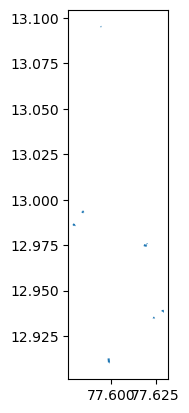

In [13]:
r["output"].plot()